# FINM 32210

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from lasso import Lasso
from sklearn.linear_model import lasso_path

## Problem 2.2

### (a)

In [2]:
# true coefficients
beta_0_true = 0
beta_true = np.array([3, -17, 5])
# generate samples
n, p = 1000, 3
X = np.random.normal(0, 1, (n, p))
eps = np.random.randn(n)
y = beta_0_true + X.dot(beta_true) + eps

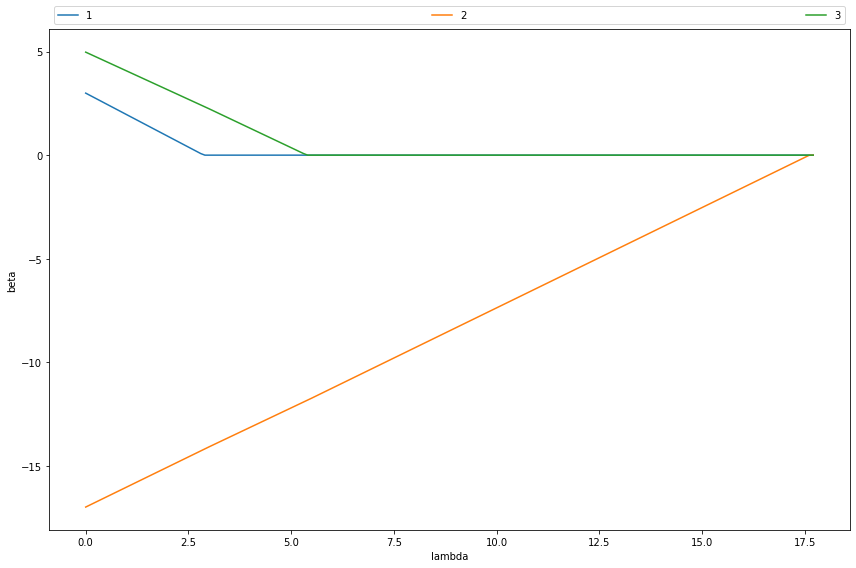

In [3]:
lasso = Lasso()
lasso.path_fit(y, X)
lasso.draw_beta_path()

### (b)
Got the same result as sklearn package

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(


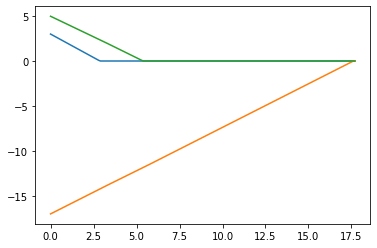

In [4]:
_, coef_path, _ = lasso_path(X, y, alphas=lasso.lmd_path, )
coef_path.shape
for j in coef_path:
    plt.plot(lasso.lmd_path, j[::-1])
plt.show()

## Problem 2.3

In [5]:
# hyperparameters
m_set, n_train, n_test, p = 100, 50, 2000, 50
length, trunc1, trunc2 = 100000, 0, 100000
lmds = np.exp(np.arange(-8, 5, 1))
step_size_dense, step_size_sparse = 0.05, 10

### (a)

In [6]:
# true coefficients
beta_true = np.random.uniform(-2, 2, p)
beta_0_true = 0
# error variance and feature variance
sig_eps = 1
sig_X = np.random.randn(p)

## (b)

In [7]:
# generate training samples
X_train_set, y_train_set = [], []
for _ in range(m_set):
    X_train = np.random.normal(0, 1, (n_train, p)) * sig_X.reshape((-1, p))
    eps_train = sig_eps * np.random.normal(0, 1, n_train)
    y_train = X_train.dot(beta_true) + eps_train
    X_train_set.append(X_train)
    y_train_set.append(y_train)

### (c)

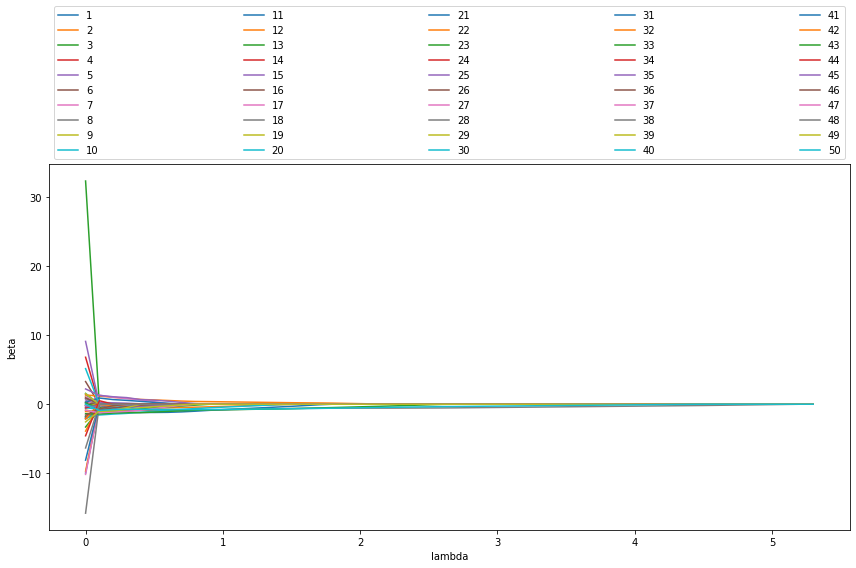

In [8]:
lasso = Lasso().path_fit(y_train_set[0], X_train_set[0])
lasso.draw_beta_path()

In [9]:
def mix_freq_mean(
    t: np.ndarray, v: np.ndarray, length: int, backward: bool = False
) -> np.ndarray:
    """Calculate the sample mean of `v` but with different timestamps `t`

    Parameters
    ----------
    t : np.ndarray
        Timestamps, N samples * T periods
    v : np.ndarray
        Values, N samples * T periods
    length : int
        Length of the new `t` and new `v`
    backward : bool, optional
        Backward take value as default or not, by default False
        
    Returns
    -------
    np.ndarray
        Mean of `v` across samples at time `t`
    """
    if t.shape != v.shape:
        raise Exception("`t` and `v` should have the same shape")
    t_, v_ = t.copy(), v.copy()
    idx = t_.argsort(axis=1)
    if backward:
        idx = idx[:, ::-1]
    for i, x in enumerate(idx):
        t_[i, :] = t_[i, x]
        v_[i, :] = v_[i, x]
    t_min, t_max = t_.min(), t_.max()
    new_t = np.linspace(t_min, t_max, length)
    new_v = []
    for nt in new_t:
        judge = t_ > nt if backward else t <= nt
        cols = judge.sum(axis=1) - 1
        rows = np.arange(len(t))[cols != -1]
        cols = cols[cols != -1]
        on_bar_v = v_[rows, cols]
        new_v.append(on_bar_v.mean())
    new_v = np.array(new_v)
    if backward:
        new_t = new_t[::-1]
        new_v = new_v[::-1]
    return new_t, new_v

Progress: 100.0%

/var/folders/rl/417hr4qj5mxbf_4xh9jq6d140000gn/T/ipykernel_26123/3209155961.py:40: RuntimeWarning: Mean of empty slice.
  new_v.append(on_bar_v.mean())
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


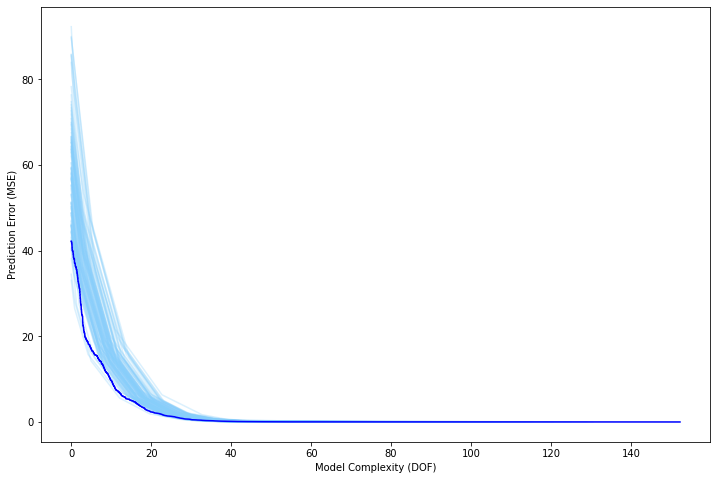

In [10]:
# train model
models = []  # m*l
dof = []  # m*l
is_mse = []  # m*l
for m in range(m_set):
    X_train, y_train = X_train_set[m], y_train_set[m]
    model_l, dof_l, is_mse_l = [], [], []
    for lmd in lmds:
        model = Lasso().fit(y_train, X_train, lmd)
        model_l.append(model)
        dof_l.append(model.dof)
        is_mse_l.append(model.score(y_train, X_train))
    models.append(model_l)
    dof.append(dof_l)
    is_mse.append(is_mse_l)
    print(f"\rProgress: {round((m + 1) / m_set * 100, 1)}%", end="")
dof = np.array(dof)
is_mse = np.array(is_mse)
# plot
plt.figure(figsize=(12, 8))
for m in range(m_set):
    plt.plot(dof[m], is_mse[m], color="#87CEFA", alpha=0.3)
is_dof_m, is_mse_m = mix_freq_mean(dof, is_mse, length, True)
is_dof_m, is_mse_m = is_dof_m[trunc1:trunc2], is_mse_m[trunc1:trunc2]
plt.plot(is_dof_m, is_mse_m, color="b")
plt.xlabel("Model Complexity (DOF)")
plt.ylabel("Prediction Error (MSE)")
plt.show()

### (d)

In [11]:
# generate training samples
X_test_set, y_test_set = [], []
for _ in range(m_set):
    X_test = np.random.normal(0, 1, (n_test, p)) * sig_X.reshape((-1, p))
    eps_test = sig_eps * np.random.normal(0, 1, n_test)
    y_test = X_test.dot(beta_true) + eps_test
    X_test_set.append(X_test)
    y_test_set.append(y_test)

Progress: 100.0%

/var/folders/rl/417hr4qj5mxbf_4xh9jq6d140000gn/T/ipykernel_26123/3209155961.py:40: RuntimeWarning: Mean of empty slice.
  new_v.append(on_bar_v.mean())
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


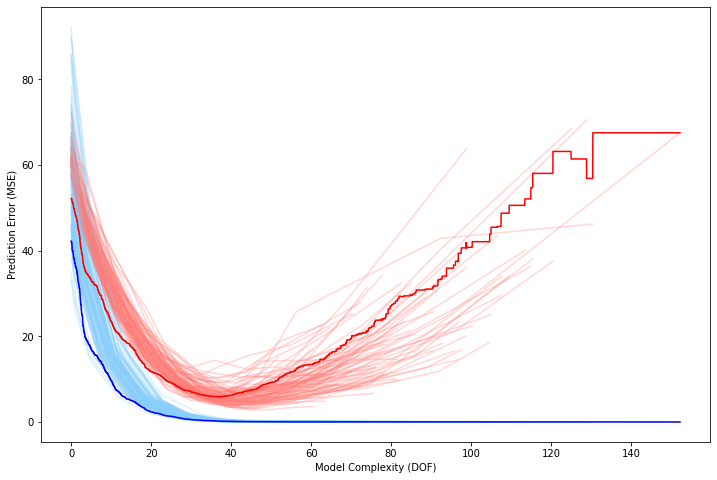

In [12]:
# test model
oos_mse = []  # m*l
for m in range(m_set):
    X_test, y_test = X_test_set[m], y_test_set[m]
    oos_mse_l = []
    model_l = models[m]
    for model in model_l:
        oos_mse_l.append(model.score(y_test, X_test))
    oos_mse.append(oos_mse_l)
    print(f"\rProgress: {round((m + 1) / m_set * 100, 1)}%", end="")
oos_mse = np.array(oos_mse)
# plot
plt.figure(figsize=(12, 8))
for m in range(m_set):
    plt.plot(dof[m], is_mse[m], color="#87CEFA", alpha=0.3)
    plt.plot(dof[m], oos_mse[m], color="#FF7E79", alpha=0.3)
oos_dof_m, oos_mse_m = mix_freq_mean(dof, oos_mse, length, True)
oos_dof_m, oos_mse_m = oos_dof_m[trunc1:trunc2], oos_mse_m[trunc1:trunc2]
plt.plot(is_dof_m, is_mse_m, color="b")
plt.plot(oos_dof_m, oos_mse_m, color="r")
plt.xlabel("Model Complexity (DOF)")
plt.ylabel("Prediction Error (MSE)")
plt.show()